d:\Programs\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
d:\Programs\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than availabl

Optimal number of clusters: 2


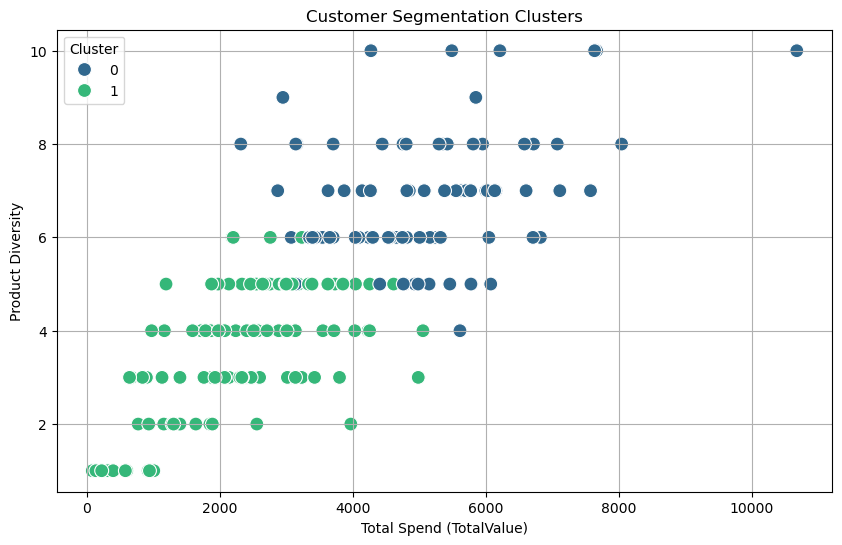

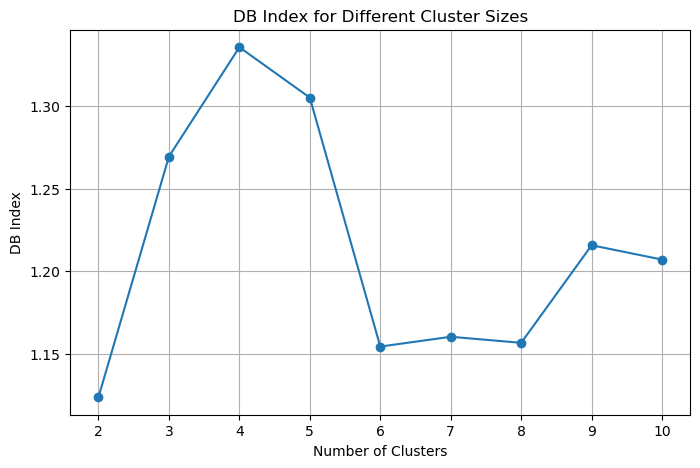

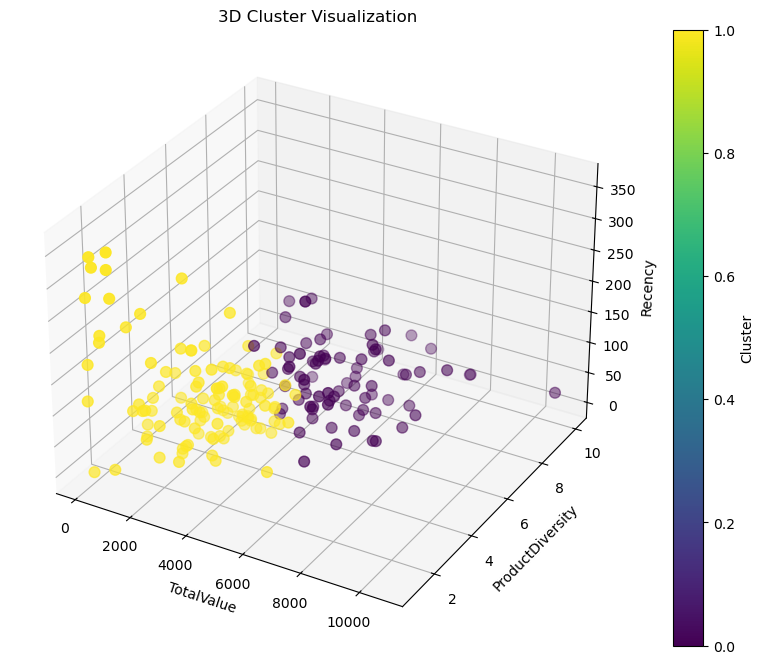

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load datasets
transactions = pd.read_csv("Transactions.csv")
customers = pd.read_csv("Customers.csv")

# Merge datasets
data = pd.merge(transactions, customers, on="CustomerID")

# Feature Engineering
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
latest_date = data['TransactionDate'].max()

# Aggregate Data
agg_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'TransactionID': 'count',
}).rename(columns={'TransactionID': 'TransactionCount'}).reset_index()

recency = data.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency['Recency'] = (latest_date - recency['TransactionDate']).dt.days
recency = recency[['CustomerID', 'Recency']]

product_diversity = data.groupby('CustomerID')['ProductID'].nunique().reset_index()
product_diversity.columns = ['CustomerID', 'ProductDiversity']

final_data = agg_data.merge(recency, on='CustomerID', how='left')
final_data = final_data.merge(product_diversity, on='CustomerID', how='left')

# Encode categorical features
customers['RegionEncoded'] = LabelEncoder().fit_transform(customers['Region'])
final_data = final_data.merge(customers[['CustomerID', 'RegionEncoded']], on='CustomerID', how='left')

# Feature Selection
features = final_data[['RegionEncoded', 'TotalValue', 'Quantity', 'TransactionCount', 
                       'ProductDiversity', 'Recency']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Clustering
k_values = range(2, 11)
db_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_scores.append(db_index)

optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Save results
final_data.to_csv("Customer_Segmentation_Final.csv", index=False)

# Visualizations
# 2D Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=final_data['TotalValue'],
    y=final_data['ProductDiversity'],
    hue=final_data['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spend (TotalValue)')
plt.ylabel('Product Diversity')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# DB Index Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o')
plt.title('DB Index for Different Cluster Sizes')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.grid()
plt.show()

# 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    final_data['TotalValue'], 
    final_data['ProductDiversity'], 
    final_data['Recency'], 
    c=final_data['Cluster'], 
    cmap='viridis', 
    s=60
)
ax.set_title('3D Cluster Visualization')
ax.set_xlabel('TotalValue')
ax.set_ylabel('ProductDiversity')
ax.set_zlabel('Recency')
plt.colorbar(scatter, ax=ax, label='Cluster')
plt.show()
